# Test Project: Classify federal register abstracts

## Step 0: Load libraries

In [1]:
import pandas as pd
import os
import numpy as np
import sys
import pickle
from collections import Counter
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

## Step 1: Get data

In [2]:
# for Windows:
dirname = os.getcwd() + "\\data\\"   
print (dirname)

/Users/austinlasseter/github_repos/federal_register\data\


In [3]:
# for Mac:
dirname = os.getcwd() + "/data/"   
print (dirname)

/Users/austinlasseter/github_repos/federal_register/data/


In [4]:
# Read in the dataset of Federal Register abstracts
df = pd.read_csv(dirname + 'fedreg10k.csv')

In [5]:
# Remove rows with empty data
print(df['abstract'].isnull().sum())
df=df.dropna(subset=['abstract'], how='all')
df.shape

2977


(7023, 17)

In [6]:
# Explore variables
df.columns

Index(['document_number', 'publication_date', 'agency_id', 'agency',
       'subagency', 'title', 'abstract', 'type', 'excerpts', 'raw_name',
       'slug', 'url', 'html_url', 'pdf_url', 'public_inspection_pdf_url',
       'json_url', 'parent_id'],
      dtype='object')

In [7]:
# 'Type' might make a good target for the classifier.
df['type'].value_counts()

Notice           5167
Rule             1140
Proposed Rule     716
Name: type, dtype: int64

In [8]:
# What are the top agencies in the dataset? This could also be a good target for the classifier.
df['agency'].value_counts().head()

Transportation Department               934
Commerce Department                     852
Health and Human Services Department    723
Homeland Security Department            602
Environmental Protection Agency         482
Name: agency, dtype: int64

In [9]:
# Create the target variable
df['target'] = (df['type'] == 'Notice')
df['target'].value_counts()

True     5167
False    1856
Name: target, dtype: int64

In [10]:
# Establish the text variable
df['abstract'][0]

'We are superseding Airworthiness Directive (AD) 2017-11-03 for DG Flugzeugbau GmbH Model DG-500MB gliders that are equipped with a Solo 2625 02 engine modified with a fuel injection system following the instructions of Solo Kleinmoteren GmbH Technische Mitteilung 4600-3 and identified as Solo 2625 02i. This AD results from mandatory continuing airworthiness information (MCAI) issued by an aviation authority of another country to identify and correct an unsafe condition on an aviation product. The MCAI describes the unsafe condition as failure of the connecting rod bearing resulting from too much load on the rod bearings from the engine control unit. This AD adds a model to the applicability. We are issuing this AD to require actions to address the unsafe condition on these products.'

In [11]:
# Remove all other variables
df=df[['target', 'abstract']]

## Step 2: Preprocess text data

In [12]:
# Strip punctuation
from utils.email_utils import stripPunctuation
df['abstract'] = df['abstract'].apply(stripPunctuation)
df['abstract'].head()

0    We are superseding Airworthiness Directive AD ...
1    The Commodity Futures Trading Commission Commi...
2    We are extending the expiration date of Endocr...
3    The Coast Guard has issued a temporary deviati...
4    The Coast Guard has issued a temporary deviati...
Name: abstract, dtype: object

In [13]:
# convert to lower case
from utils.email_utils import preprocess
df['abstract'] = df['abstract'].apply(preprocess)
df['abstract'].head()

0    we are superseding airworthiness directive ad ...
1    the commodity futures trading commission commi...
2    we are extending the expiration date of endocr...
3    the coast guard has issued a temporary deviati...
4    the coast guard has issued a temporary deviati...
Name: abstract, dtype: object

In [14]:
# examine the tokenizer that we'll use in the next step (note: this is just exploratory and does not modify the data)
from utils.email_utils import myTokenizer
df['abstract'].apply(myTokenizer.tokenize).head()

0    [we, are, superseding, airworthiness, directiv...
1    [the, commodity, futures, trading, commission,...
2    [we, are, extending, the, expiration, date, of...
3    [the, coast, guard, has, issued, a, temporary,...
4    [the, coast, guard, has, issued, a, temporary,...
Name: abstract, dtype: object

In [15]:
# Count the tokens (note: this is just exploratory and does not modify the data)
from utils.email_utils import countTokens
df['abstract'].apply(countTokens).head()

0    124
1    158
2     70
3    101
4     63
Name: abstract, dtype: int64

## Step 3: Split and Vectorize the data

In [16]:
# Establish our X and y
X = df['abstract']
y = df['target']

In [17]:
# Let's set aside 33% of our data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [18]:
# Instantiate a TFidf vectorizer. Note the tokenizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', 
                             max_df=0.5, tokenizer=myTokenizer.tokenize)

In [19]:
# Train the vectorizer
tvec_train = vectorizer.fit_transform(X_train)

In [20]:
# Save feature names in a separate list for later use
feature_names = vectorizer.get_feature_names()
print('First 5 features:', feature_names[:5])
print('Last 5 features:', feature_names[-5:])

First 5 features: ['0', '000', '0003', '0007', '0011']
Last 5 features: ['zoning', 'zontivity', 'zoxamide', 'zstiffeners', 'zydelig']


## Step 4: Instantiate, Tune and Train a Logistic Regression Classifier

In [21]:
# Set up the parameters for the gridsearch.
gs_params = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.logspace(-5,0,100)
}

In [22]:
# Instantiate the gridsearch
lr_gridsearch = GridSearchCV(LogisticRegression(), param_grid=gs_params, cv=5, verbose=1)

In [23]:
# Fit the instantiated gridsearch to the vectorized training data
lr_gridsearch.fit(tvec_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([  1.00000e-05,   1.12332e-05, ...,   8.90215e-01,   1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [24]:
# Display the best parameters and the score associated with them
print(lr_gridsearch.best_params_)
print(lr_gridsearch.best_score_)

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.954941551541


In [25]:
# Instantiate model using those parameters
model_lr = lr_gridsearch.best_estimator_
print(model_lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


## Step 5: Classify the test data

In [26]:
#Create another matrix of tfidf scores for the documents in the test set
tvec_test = vectorizer.transform(X_test)

In [27]:
# Predict on the test data
predictions=model_lr.predict(tvec_test)
predictions

array([ True,  True,  True, ..., False,  True,  True], dtype=bool)

In [28]:
# Probabilities
probabilities = model_lr.predict_proba(tvec_test)[:,1]
probabilities

array([ 0.98516365,  0.77881781,  0.9214669 , ...,  0.27956391,
        0.84912411,  0.90813232])

In [29]:
# Score
model_lr.score(tvec_test, y_test)

0.96117342536669548

In [30]:
# Convert each component to a pandas dateframe
df_probs=pd.DataFrame(probabilities, columns=['probabilities']).reset_index(drop=True)
df_preds=pd.DataFrame(predictions, columns=['predictions']).reset_index(drop=True)
df_Xtest=pd.DataFrame(X_test).reset_index(drop=True)
df_ytest=pd.DataFrame(y_test).reset_index(drop=True)
# Reset a new index because we removed all the training data but never reset the index, so it has gaps
# and drop=True gets rid of the old index

final=pd.concat([df_Xtest, df_ytest, df_probs, df_preds], axis=1)
final.head()

,abstract,target,probabilities,predictions
0,the department of labor dol is submitting the ...,True,0.985164,True
1,automated driving systems ads are increasingly...,True,0.778818,True
2,the department of the air force hereby gives n...,True,0.921467,True
3,the food and drug administration fda or agency...,False,0.805462,True
4,we are superseding airworthiness directive ad ...,False,0.058034,False


In [31]:
# Let's look at some that had high probability of being assigned to the target type=rule
final[(final['probabilities']<0.1)].head(5)

,abstract,target,probabilities,predictions
4,we are superseding airworthiness directive ad ...,False,0.058034,False
6,the coast guard proposes to establish a tempor...,False,0.032872,False
22,the coast guard proposes to establish a tempor...,False,0.061874,False
43,we propose to adopt a new airworthiness direct...,False,0.076899,False
59,the coast guard proposes to establish a tempor...,False,0.026960,False


In [32]:
# Let's look at some that had high probability of NOT being assigned to the target agency
final[(final['probabilities']>0.9)].head(5)

,abstract,target,probabilities,predictions
0,the department of labor dol is submitting the ...,True,0.985164,True
2,the department of the air force hereby gives n...,True,0.921467,True
5,the food and drug administration fda is announ...,True,0.988450,True
10,the environmental protection agency epa has su...,True,0.985347,True
18,notice is hereby given pursuant to the provisi...,True,0.965381,True


In [33]:
# Let's look at some that had intermediate probability
final[(final['probabilities']!=0.0) & (final['probabilities']!=1.0)].head(10)

,abstract,target,probabilities,predictions
0,the department of labor dol is submitting the ...,True,0.985164,True
1,automated driving systems ads are increasingly...,True,0.778818,True
2,the department of the air force hereby gives n...,True,0.921467,True
3,the food and drug administration fda or agency...,False,0.805462,True
4,we are superseding airworthiness directive ad ...,False,0.058034,False
5,the food and drug administration fda is announ...,True,0.988450,True
6,the coast guard proposes to establish a tempor...,False,0.032872,False
7,the commodity futures trading commission cftc ...,True,0.778845,True
8,the fdic is issuing this technical amendment t...,False,0.198971,False
9,this final rule amends national institute of f...,False,0.329405,False


## Step 6: Evaluate Results
<p>Nice summary of different formulas for accuracy, precision, recall, etc 
<a href="http://www.damienfrancois.be/blog/files/modelperfcheatsheet.pdf">here</a></p>

In [34]:
#Write out results
final.head()

,abstract,target,probabilities,predictions
0,the department of labor dol is submitting the ...,True,0.985164,True
1,automated driving systems ads are increasingly...,True,0.778818,True
2,the department of the air force hereby gives n...,True,0.921467,True
3,the food and drug administration fda or agency...,False,0.805462,True
4,we are superseding airworthiness directive ad ...,False,0.058034,False


In [35]:
#Now let's see how well this model did, true positives, false positives, etc
def accuracy(tp, tn, fp, fn):
    return ((tp + tn)/(tp + tn + fp + fn))

def error_rate(tp, tn, fp, fn):
    return ((fp + fn)/ (tp + tn + fp + fn))

true_positives = len(final.loc[(final['target'] == True) & (final['predictions'] == True)])
false_positives = len(final.loc[(final['target'] == False) & (final['predictions'] == True)])
true_negatives = len(final.loc[(final['target'] == False) & (final['predictions'] == False)])
false_negatives = len(final.loc[(final['target'] == True) & (final['predictions'] == False)])
print("Results\nTrue Positives\tTrue_Negatives\tFalse_Positives\False_Negatives\n")
print("\t".join(map(str, [true_positives, true_negatives, false_positives, false_negatives])))

print("Classifier Accuracy: {}\n".format(accuracy(true_positives, true_negatives, 
                                                  false_positives, false_negatives)))
print("Classifier Error Rate: {}\n".format(error_rate(true_positives, true_negatives,
                                                      false_positives, false_negatives)))


Results
True Positives	True_Negatives	False_Positives\False_Negatives

1717	511	87	3
Classifier Accuracy: 0.9611734253666955

Classifier Error Rate: 0.03882657463330457



### Pickle my results for use in dashboard

In [36]:
#First get the predicted class label for each document
predictions = model_lr.predict(tvec_test)
print("Accuracy score for your classifier: {:.3f}\n".format(model_lr.score(tvec_test, y_test)))
print("Error rate for your classifier: {:.3f}\n".format(1-model_lr.score(tvec_test, y_test)))
classifierStats = dict()
classifierStats['accuracy'] = model_lr.score(tvec_test, y_test)
classifierStats['errorRate'] = (1 - model_lr.score(tvec_test, y_test))

Accuracy score for your classifier: 0.961

Error rate for your classifier: 0.039



In [37]:
#Also store the predicted class probabilities
predictProbabilities = model_lr.predict_proba(tvec_test)
predictProbabilities[0]

array([ 0.01483635,  0.98516365])

In [38]:
def truth_value(myRow):
    if (myRow['ground_truth'] == True and myRow['predicted_value'] == True):
        return 'truePositive'
    elif (myRow['ground_truth'] == True and myRow['predicted_value'] == False):
        return 'falseNegative'
    elif (myRow['ground_truth'] == False and myRow['predicted_value'] == True):
        return 'falsePositive'
    elif (myRow['ground_truth'] == False and myRow['predicted_value'] == False):
        return 'trueNegative'
    else:
        return None

In [39]:
print(len(y_test))
print(len(predictions))

2318
2318


In [40]:
y_test.head()

4559     True
9827     True
5794     True
9621    False
8938    False
Name: target, dtype: bool

In [41]:
print(type(predictions))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [42]:
y_test_array=y_test.values

In [43]:
print(type(predictions))
print(type(y_test_array))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [44]:
# Define the results dataset
results = [(y_test_array[i], predictions[i]) for i in range(0,len(predictions))]

In [45]:
y_test_array

array([ True,  True,  True, ..., False,  True,  True], dtype=bool)

In [46]:
#Add in the email id, subject, and body, then truePos, falsePos, trueNeg, falseNeg, posProbability, negProbability
enrichedResults = pd.DataFrame.from_records(results, 
    columns = ['ground_truth', 'predicted_value'])

In [47]:
enrichedResults.head()

,ground_truth,predicted_value
0,True,True
1,True,True
2,True,True
3,False,True
4,False,False


In [48]:
enrichedResults['truthValue'] = enrichedResults.apply(lambda row: truth_value(row), axis=1)
enrichedResults.head()

,ground_truth,predicted_value,truthValue
0,True,True,truePositive
1,True,True,truePositive
2,True,True,truePositive
3,False,True,falsePositive
4,False,False,trueNegative


In [49]:
enrichedResults['abstract'] = X_test.tolist()
enrichedResults['posProbability'] = [prob[1] for prob in predictProbabilities]
enrichedResults['negProbability'] = [prob[0] for prob in predictProbabilities]
enrichedResults.head()

,ground_truth,predicted_value,truthValue,abstract,posProbability,negProbability
0,True,True,truePositive,the department of labor dol is submitting the ...,0.985164,0.014836
1,True,True,truePositive,automated driving systems ads are increasingly...,0.778818,0.221182
2,True,True,truePositive,the department of the air force hereby gives n...,0.921467,0.078533
3,False,True,falsePositive,the food and drug administration fda or agency...,0.805462,0.194538
4,False,False,trueNegative,we are superseding airworthiness directive ad ...,0.058034,0.941966


In [50]:
counts = enrichedResults['truthValue'].value_counts()
for i in range(0,len(counts)):
    classifierStats[counts.index[i]] = counts[i]
with open('classifierStats.pyc', 'wb') as f:
    pickle.dump(classifierStats, f)
f.close()
with open('classifierTestResults.pyc', 'wb') as f1:
    pickle.dump(enrichedResults, f1)
f1.close()

### Evaluate NB using metrics module

In [51]:
from sklearn import metrics
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

      False       0.99      0.85      0.92       598
       True       0.95      1.00      0.97      1720

avg / total       0.96      0.96      0.96      2318



In [52]:
# Our ROC-AUC score measures the trade-off between specificity and sensitivity
from sklearn.metrics import roc_auc_score
roc_score=100*roc_auc_score(y_test, predictions)
print(roc_score)

92.638543206


### Which features are most informative?

In [53]:
# Create a dataframe of the features by importance
importance=pd.DataFrame(sorted(zip(model_lr.coef_[0], feature_names)), columns=['modelCoef', 'term'])
# Remember, the target is defined as df['type'] == 'Notice' rather than 'Rule'

In [54]:
importance.head()

,modelCoef,term
0,-7.022927,rule
1,-3.957040,regulations
2,-3.455134,regulation
3,-3.313241,rulemaking
4,-3.122209,action


In [55]:
# Features most associated with target=False
high5=pd.DataFrame(importance.head(5))
low5=pd.DataFrame(importance.tail(5))
top10=pd.concat([high5, low5], ignore_index=True)
top10.head()

,modelCoef,term
0,-7.022927,rule
1,-3.957040,regulations
2,-3.455134,regulation
3,-3.313241,rulemaking
4,-3.122209,action


In [56]:
# Features most associated with target=False
high50=pd.DataFrame(importance.head(50))
low50=pd.DataFrame(importance.tail(50))
top100=pd.concat([high50, low50], ignore_index=True)
top100.head()

,modelCoef,term
0,-7.022927,rule
1,-3.957040,regulations
2,-3.455134,regulation
3,-3.313241,rulemaking
4,-3.122209,action


In [57]:
top100.to_csv('termScores.csv', index=False)

Text(0,0.5,'Coefficient')

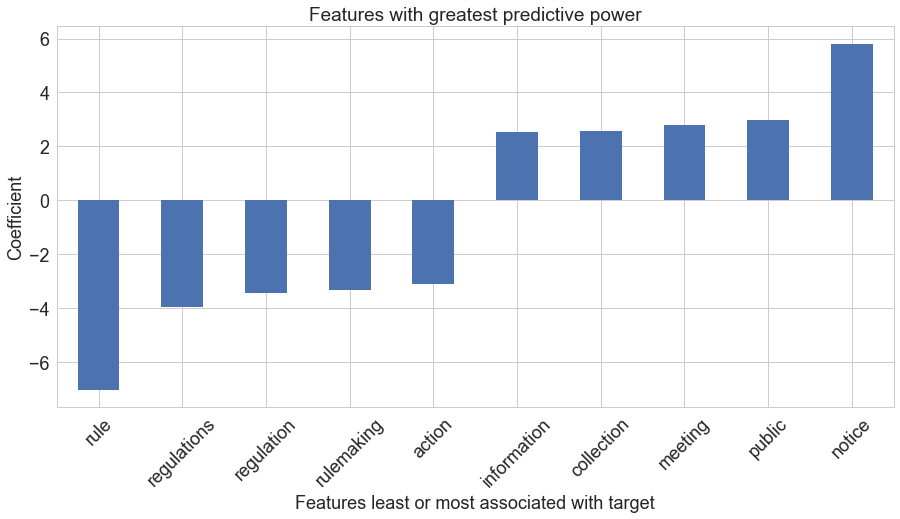

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
ax = top10.set_index('term').plot(kind='bar', legend=False, fontsize=18, figsize=(15, 7))
plt.title('Features with greatest predictive power',  fontsize=19)

plt.xticks(rotation = 45,  fontsize=18)
plt.xlabel('Features least or most associated with target', fontsize=18)
plt.yticks(rotation = 0,  fontsize=18)
plt.ylabel('Coefficient', rotation=90,  fontsize=18)

In [59]:
from sklearn.metrics import roc_curve, auc

# ROC-AUC Score
FPR = dict()
TPR = dict()
ROC_AUC = dict()
# For the target class, find the area under the curve:
FPR[1], TPR[1], _ = roc_curve(y_test, probabilities)
ROC_AUC[1] = auc(FPR[1], TPR[1])

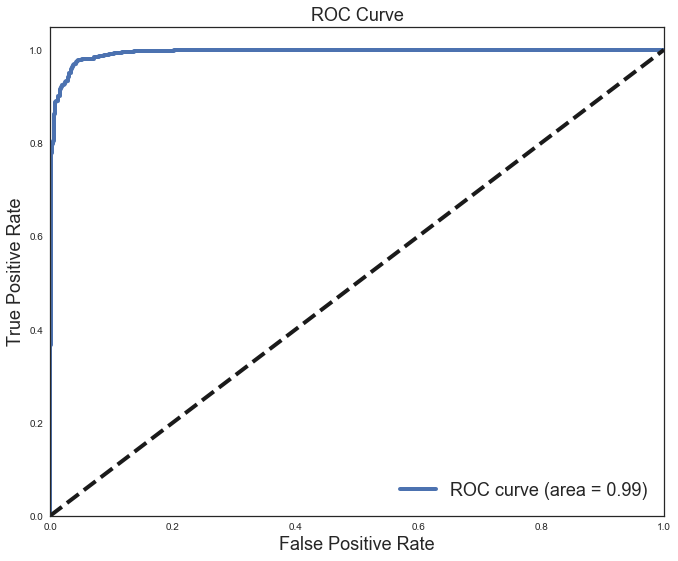

In [60]:
# Let's draw that:
plt.style.use('seaborn-white')
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve', fontsize=18)
plt.legend(loc="lower right", fontsize=18);
plt.savefig('rocauc.png', dpi=300, bbox_inches='tight')

In [61]:
from sklearn.metrics import roc_auc_score
roc_score=round(100*roc_auc_score(y_test, predictions),1)
print(roc_score)

92.6


In [62]:
fpr, tpr, thresholds=roc_curve(y_test, predictions)

In [63]:
fpr

array([ 0.        ,  0.14548495,  1.        ])

In [64]:
type(test)

NameError: name 'test' is not defined

In [ ]:
test[2]

In [ ]:
enrichedResults['truthValue'].head()

y_test=enrichedResults['ground_truth']
predictions=enrichedResults['predicted_value']
probabilities=enrichedResults['posProbability']

In [ ]:
fpr, tpr, _ = roc_curve(y_test, probabilities)

In [ ]:
# if this doesn't work then: 
# Open Jupyter with: jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()


import plotly
import plotly.graph_objs as go

iplot({
    'data': [{
        'x': fpr,
        'y': tpr,
        'type': 'scatter',
        'mode': 'lines', # 'markers' | 'lines+markers',
        'name': 'AUC: '+str(roc_score)
    },
    {
        'x': [0,1],
        'y': [0,1],
        'type': 'scatter',
        'mode': 'lines', # 'markers' | 'lines+markers'
        'name': 'Baseline Area: 50.0'
    }],
    'layout': {
        'title': 'Receiver Operating Characteristic (ROC) Curve',
        'xaxis': {
            'title': 'False Positive Rate (100-Specificity)',
            'scaleratio': 1,
            'scaleanchor': 'y'
        },
        'yaxis': {
            'title': 'True Positive Rate (Sensitivity)'
        }
    }
})

In [ ]:
iplot({
    'data': [{
        'x': top10['term'],
        'y': top10['modelCoef'],
        'type': 'bar'
    }],
    'layout': {
        'title': 'Most Important Features',
        'xaxis': {
            'title': 'Feature'
        },
        'yaxis': {
            'title': 'Logistic Regression Model Coefficient'
        }
    }
})

In [ ]:
with open('top10.pyc', 'wb') as f1:
    pickle.dump(top10, f1)
f1.close()